In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pose_graph_partitioning.pose_graph import *
from pose_graph_partitioning.tsp_dataset_generation import *
from pose_graph_partitioning.pose_graph_partitioning import *
from simulate_bdslam import *
import pickle
import os


In [2]:
optimizer_path = "/home/xuhao/source/distributed-mapper/distributed_mapper_core/cpp/build/runDistributedMapper"
def pocess_DGS_result(output):
    import re
    iterations = int(re.findall("\[optimizeRotation\] Finish iteration(\d+)", output, flags=0)[0])
    iterations += int(re.findall("\[optimizePoses\] Finish iteration(\d+)", output, flags=0)[0])
    min_time = float(re.findall("\[DGS\] min ([0-9]+\.?[0-9]*)ms", output, flags=0)[0])
    max_time = float(re.findall("\[DGS\] max ([0-9]+\.?[0-9]*)ms", output, flags=0)[0])
    initial = float(re.findall("Initial error (\S+)", output, flags=0)[0])
    final = float(re.findall("Distributed Error:\s+(\S+)", output, flags=0)[0])
    return iterations, min_time, max_time, initial, final

def generate_data(data_file, data_folder, agent_num, initial_partition="id"):
    pg = PoseGraph()
    pg.read_g2o_single(data_file)
    title = data_folder.split("/")[-1]
    try:
        pg2 = PoseGraph()
        pg2.read_g2o_single(f"{data_folder}/parted-initial/fullGraph_optimized.g2o")
        pg2.show(title+"_initial_optimized")
        print("Loaded initial optimized")
    except:
        print("No inital optimized, computing")
        #Write to folder
    #     partitioning(pg, "vol", agent_num=agent_num, show=False)
        partitioning(pg, "vol", agent_num=agent_num, show=False, method=initial_partition)
        pg.show("parted")
        pg.write_to_g2o_folder(f"{data_folder}/parted-initial", cvt_id=True)
        #call optimizer to optimize the data here
        command = f"{optimizer_path}  --nrRobots {agent_num} --dataDir {data_folder}/parted-initial/ --pthresh 0.01  --rthresh 0.01   --maxIter 1000"
        print("Call distributed optimizer from initial optimize")
        s = os.popen(command)
        output = s.read()

        iterations, min_time, max_time, initial, final = pocess_DGS_result(output)
        print(f"max_time {max_time}, iterations {iterations}, initial {initial}, final {final}")
        pg2 = PoseGraph()
        pg2.read_g2o_single(f"{data_folder}/parted-initial/fullGraph_optimized.g2o")
        pg2.show("initial_optimized")
        print("Loaded initial optimized")
    
    # Generate path from g2o
    #We load the optimized result of g2o and constructed edge between the disconnected poses, after that we load the initial value again.
    tsp_pathes_cache_file = f"{data_folder}/mTSP-pathes-{agent_num}.npy"
    try:
        pathes = np.load(tsp_pathes_cache_file, allow_pickle=True)
        pathes = generate_path_tsp(pg, agent_num, random_weight=True, pg_optimized=pg2, fix_path=True, align_beginning=True, pathes=pathes)
        print("Loaded pathes from file.....")
    except:
        print("No current mTSP pathes found, generating mTSP pathes.....")
        pathes = generate_path_tsp(pg, agent_num, random_weight=True, pg_optimized=pg2, fix_path=True, align_beginning=True)
        np.save(tsp_pathes_cache_file, pathes)    
    
    pg.write_to_g2o_folder(f"{data_folder}/mTSP", cvt_id=True)
    pg.update_edges()
    cut, vol, min_keyframes, max_keyframes,  kf_num, edge_num = pg.statistical()
    print(f"mTSP optimizing..... cut {cut} vol {vol}  edge_num{edge_num} unb {max_keyframes/min_keyframes:.2f}, kf_num{kf_num}")

    command = f"{optimizer_path}  --nrRobots {agent_num} --dataDir {data_folder}/mTSP/  --maxIter 100"
    s = os.popen(command)
    output = s.read()
    iterations, min_time, max_time, initial, final = pocess_DGS_result(output)
    print(f"max_time {max_time:.1f}ms iterations {iterations}, initial {initial:.2f}, final {final:.2f} totalv {iterations*vol}\n")

    repart_keyframe = 100
    comm_range = 100000
    comm_mode = "router"

    _pg = copy.deepcopy(pg)
    pgms, cuts, vols, unbs, network_clusters = simulate_realtime_multiagents_slam2(_pg, pathes, use_greedy=False,
    use_repart=True, repart_keyframe=repart_keyframe, 
    comm_range=comm_range, comm_mode=comm_mode,show=False,verbose=False)

    pgms[0].pg.update_edges()
    cut, vol, min_keyframes, max_keyframes,  kf_num, edge_num = pgms[0].pg.statistical()
    print(f"mTSP-NoGreedy optimizing..... cut {cut} vol {vol}  edge_num{edge_num}  unb {max_keyframes/min_keyframes:.2f},  kf_num{kf_num}")
    addition_edges = run_distributed_solver_cluster(pgms, f"{data_folder}/mTSP-parted-proposed", debug=True)
    command = f"{optimizer_path}  --nrRobots {agent_num} --dataDir {data_folder}/mTSP-parted-proposed/  --maxIter 100"
    s = os.popen(command)
    output = s.read()
    iterations, min_time, max_time, initial, final = pocess_DGS_result(output)
    print(f"addition_edges {addition_edges} max_time {max_time:.1f}ms  iterations {iterations} initial {initial:.2f} final {final:.2f} totalv {iterations*vol}\n")

    _pg = copy.deepcopy(pg)
    pgms, cuts, vols, unbs, network_clusters = simulate_realtime_multiagents_slam2(_pg, pathes, use_greedy=True,
        use_repart=True, repart_keyframe=repart_keyframe, 
        comm_range=comm_range, comm_mode=comm_mode,show=False,verbose=False)

    pgms[0].pg.update_edges()
    cut, vol, min_keyframes, max_keyframes,  kf_num, edge_num = pgms[0].pg.statistical()
    print(f"mTSP-proposed optimizing..... cut {cut} vol {vol}  edge_num{edge_num}  unb {max_keyframes/min_keyframes:.2f},  kf_num{kf_num}")
    addition_edges = run_distributed_solver_cluster(pgms, f"{data_folder}/mTSP-parted-proposed", debug=True)
    command = f"{optimizer_path}  --nrRobots {agent_num} --dataDir {data_folder}/mTSP-parted-proposed/  --maxIter 100"
    s = os.popen(command)
    output = s.read()
    iterations, min_time, max_time, initial, final = pocess_DGS_result(output)
    print(f"addition_edges {addition_edges} max_time {max_time:.1f}ms  iterations {iterations} initial {initial:.2f} final {final:.2f} totalv {iterations*vol}")
    
    pg2 = PoseGraph()
    pg2.read_g2o_single(f"{data_folder}/mTSP-parted-proposed/fullGraph_optimized.g2o")
    pg2.show(title+"_proposed")


Total agents 1 keyframes 5000 edges 9048 inter edge 0 comm_vol 0
Total agents 1 keyframes 5000 edges 9048 inter edge 0 comm_vol 0


/home/xuhao/swarm_ws/src/distributed_solver/dslam_pose_graph_opti/scripts/pose_graph_partitioning/pose_graph.py:712: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='3d')


Loaded initial optimized
Fix 114 disconnected edges now edges 9162
TSP new path keyframes 42<->1165 cut 1604 comm_vol 2703
Loaded pathes from file.....
Wrote 10766 edges total 9162
mTSP optimizing..... cut 1604 vol 2703  edge_num9162 unb 27.74, kf_num5000
max_time 540.2ms iterations 56, initial 22988.30, final 90.05 totalv 151368

Partition agents 10 .... cut 539 vol 999  edge_num9162  unb 1.14,  kf_num5000
mTSP-NoGreedy optimizing..... cut 539 vol 999  edge_num9162  unb 1.14,  kf_num5000
addition_edges 9 max_time 170.7ms  iterations 33 initial 23480.40 final 90.34 totalv 32967

Partition agents 10 .... cut 550 vol 1036  edge_num9162  unb 1.21,  kf_num5000
mTSP-proposed optimizing..... cut 550 vol 1036  edge_num9162  unb 1.21,  kf_num5000
addition_edges 1 max_time 128.8ms  iterations 25 initial 23187.90 final 89.77 totalv 25900
Total agents 1 keyframes 5000 edges 9163 inter edge 0 comm_vol 0


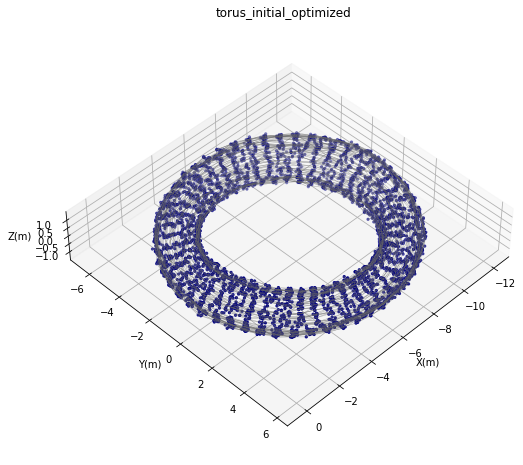

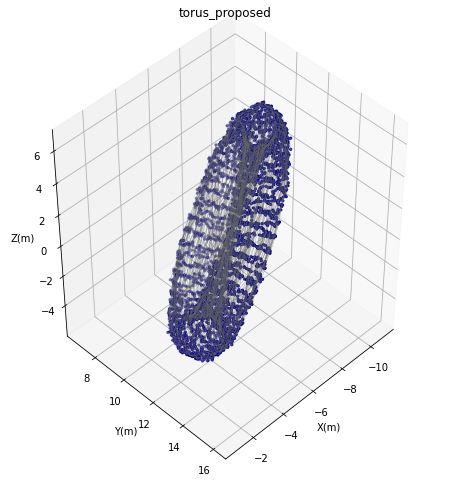

In [3]:
generate_data("/home/xuhao/data/ral2021/raw/torus3D.g2o",  "/home/xuhao/data/ral2021/DGS/torus", 10)

Total agents 1 keyframes 8000 edges 22236 inter edge 0 comm_vol 0
Total agents 1 keyframes 8000 edges 22236 inter edge 0 comm_vol 0
Loaded initial optimized
Fix 58 disconnected edges now edges 22294
TSP new path keyframes 95<->1819 cut 8544 comm_vol 11514
Loaded pathes from file.....
Wrote 30838 edges total 22294
mTSP optimizing..... cut 8544 vol 11514  edge_num22294 unb 19.15, kf_num8000
max_time 1304.3ms iterations 59, initial 747844.20, final 310.63 totalv 679326

Partition agents 10 .... cut 2090 vol 3339  edge_num22294  unb 1.18,  kf_num8000
mTSP-NoGreedy optimizing..... cut 2090 vol 3339  edge_num22294  unb 1.18,  kf_num8000
addition_edges 11 max_time 854.6ms  iterations 33 initial 753010.00 final 310.90 totalv 110187

Partition agents 10 .... cut 2036 vol 3309  edge_num22294  unb 1.16,  kf_num8000
mTSP-proposed optimizing..... cut 2036 vol 3309  edge_num22294  unb 1.16,  kf_num8000
addition_edges 0 max_time 510.2ms  iterations 21 initial 747844.20 final 309.60 totalv 69489
Total

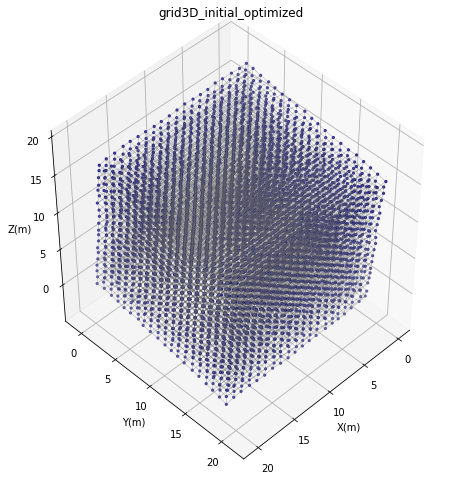

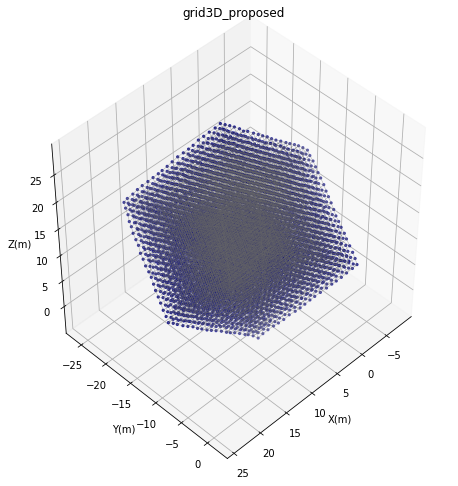

In [4]:
generate_data("/home/xuhao/data/ral2021/raw/grid3D.g2o",  "/home/xuhao/data/ral2021/DGS/grid3D", 10)

Total agents 1 keyframes 2200 edges 8647 inter edge 0 comm_vol 0
Total agents 1 keyframes 2200 edges 8647 inter edge 0 comm_vol 0
Loaded initial optimized
Fix 15 disconnected edges now edges 8662
TSP new path keyframes 80<->534 cut 1665 comm_vol 1389
Loaded pathes from file.....
Wrote 10327 edges total 8662
mTSP optimizing..... cut 1665 vol 1389  edge_num8662 unb 6.67, kf_num2200
max_time 767.1ms iterations 105, initial 80750584.30, final 1875.71 totalv 145845

Partition agents 10 .... cut 855 vol 803  edge_num8662  unb 1.18,  kf_num2200
mTSP-NoGreedy optimizing..... cut 855 vol 803  edge_num8662  unb 1.18,  kf_num2200
addition_edges 8 max_time 370.8ms  iterations 103 initial 81158861.90 final 6179.58 totalv 82709

Partition agents 10 .... cut 771 vol 685  edge_num8662  unb 1.14,  kf_num2200
mTSP-proposed optimizing..... cut 771 vol 685  edge_num8662  unb 1.14,  kf_num2200
addition_edges 0 max_time 353.0ms  iterations 103 initial 80750584.30 final 1907.69 totalv 70555
Total agents 1 ke

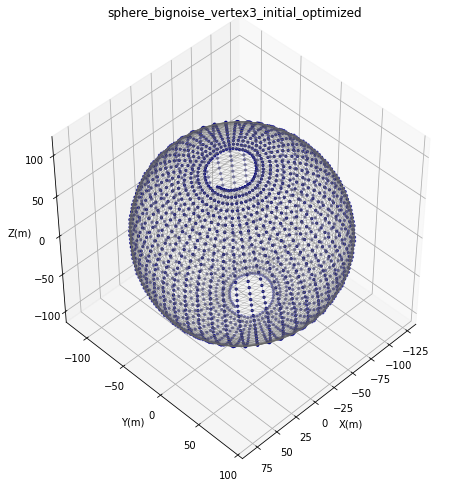

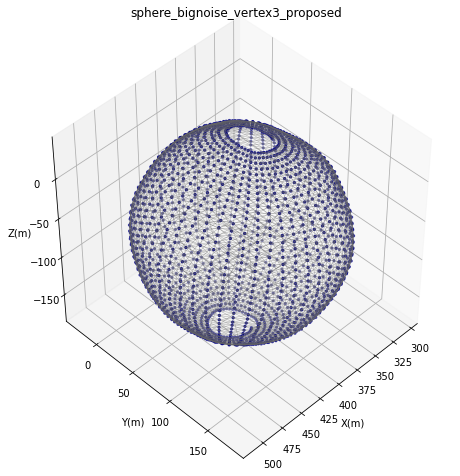

In [5]:
generate_data("/home/xuhao/data/ral2021/raw/sphere_bignoise_vertex3.g2o",  "/home/xuhao/data/ral2021/DGS/sphere_bignoise_vertex3", 10)

Total agents 1 keyframes 5750 edges 12486 inter edge 0 comm_vol 0
Total agents 1 keyframes 5750 edges 12486 inter edge 0 comm_vol 0
Loaded initial optimized
Fix 107 disconnected edges now edges 12593
TSP new path keyframes 20<->1357 cut 3333 comm_vol 4672
Loaded pathes from file.....
Wrote 15926 edges total 12593
mTSP optimizing..... cut 3333 vol 4672  edge_num12593 unb 67.85, kf_num5750
max_time 159.5ms iterations 13, initial 33846.00, final 5.42 totalv 60736

Partition agents 10 .... cut 878 vol 1345  edge_num12593  unb 1.22,  kf_num5750
mTSP-NoGreedy optimizing..... cut 878 vol 1345  edge_num12593  unb 1.22,  kf_num5750
addition_edges 12 max_time 130.6ms  iterations 12 initial 34888.00 final 5.29 totalv 16140

Partition agents 10 .... cut 578 vol 920  edge_num12593  unb 1.11,  kf_num5750
mTSP-proposed optimizing..... cut 578 vol 920  edge_num12593  unb 1.11,  kf_num5750
addition_edges 1 max_time 287.2ms  iterations 23 initial 33980.70 final 5.28 totalv 21160
Total agents 1 keyframes

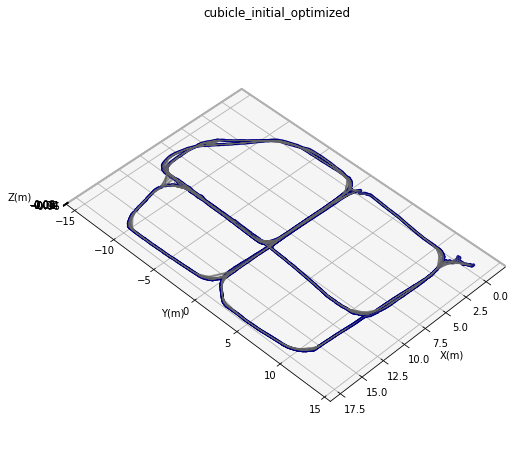

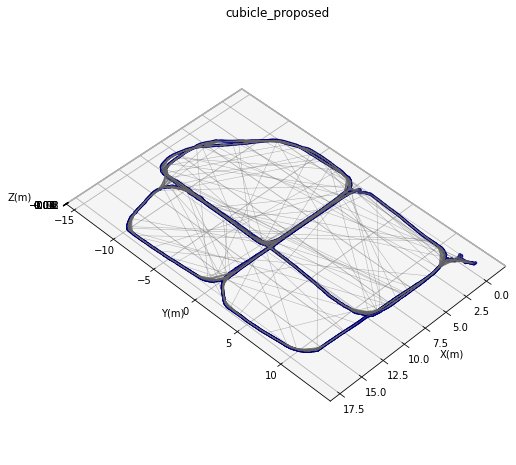

In [6]:
generate_data("/home/xuhao/data/ral2021/raw/cubicle.g2o",  "/home/xuhao/data/ral2021/DGS/cubicle", 10)

Total agents 1 keyframes 1661 edges 6275 inter edge 0 comm_vol 0
Total agents 1 keyframes 1661 edges 6275 inter edge 0 comm_vol 0
Loaded initial optimized
Fix 30 disconnected edges now edges 6305
TSP new path keyframes 8<->444 cut 901 comm_vol 515
Loaded pathes from file.....
Wrote 7206 edges total 6305
mTSP optimizing..... cut 901 vol 515  edge_num6305 unb 55.50, kf_num1661
max_time 484.9ms iterations 100, initial 8493.00, final 1.57 totalv 51500

Partition agents 10 .... cut 228 vol 244  edge_num6305  unb 1.13,  kf_num1661
mTSP-NoGreedy optimizing..... cut 228 vol 244  edge_num6305  unb 1.13,  kf_num1661
addition_edges 12 max_time 74.0ms  iterations 22 initial 8571.60 final 0.75 totalv 5368

Partition agents 10 .... cut 153 vol 168  edge_num6305  unb 1.13,  kf_num1661
mTSP-proposed optimizing..... cut 153 vol 168  edge_num6305  unb 1.13,  kf_num1661
addition_edges 1 max_time 345.7ms  iterations 92 initial 8494.10 final 0.73 totalv 15456
Total agents 1 keyframes 1661 edges 6306 inter 

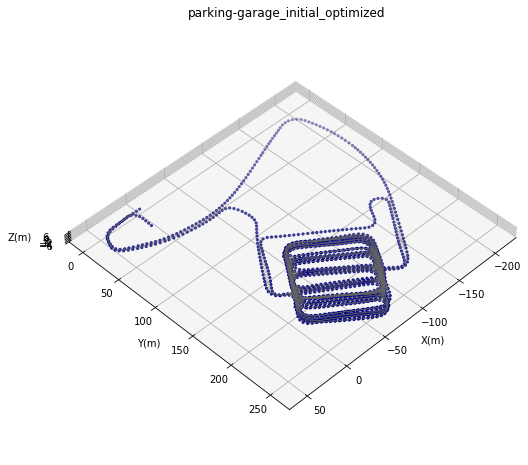

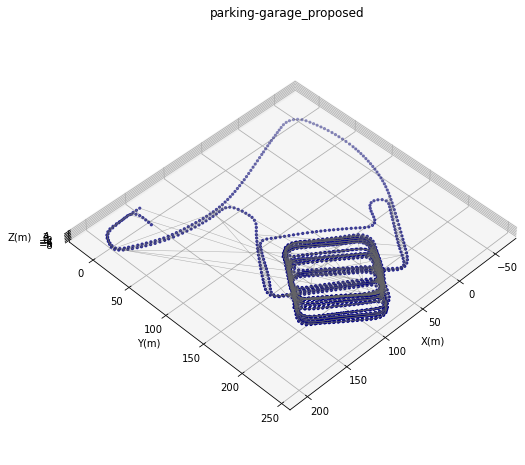

In [7]:
generate_data("/home/xuhao/data/ral2021/raw/parking-garage.g2o",  "/home/xuhao/data/ral2021/DGS/parking-garage", 10)

Total agents 1 keyframes 1228 edges 1483 inter edge 0 comm_vol 0
Total agents 1 keyframes 1228 edges 1483 inter edge 0 comm_vol 0
Loaded initial optimized
Fix 18 disconnected edges now edges 1501
TSP new path keyframes 6<->375 cut 209 comm_vol 239
Loaded pathes from file.....
Wrote 1710 edges total 1501
mTSP optimizing..... cut 209 vol 239  edge_num1501 unb 62.50, kf_num1228
max_time 133.5ms iterations 49, initial 32590.90, final 0.95 totalv 11711

Partition agents 10 .... cut 112 vol 180  edge_num1501  unb 1.23,  kf_num1228
mTSP-NoGreedy optimizing..... cut 112 vol 180  edge_num1501  unb 1.23,  kf_num1228
addition_edges 15 max_time 16.5ms  iterations 14 initial 34100.60 final 0.61 totalv 2520

Partition agents 10 .... cut 98 vol 160  edge_num1501  unb 1.19,  kf_num1228
mTSP-proposed optimizing..... cut 98 vol 160  edge_num1501  unb 1.19,  kf_num1228
addition_edges 3 max_time 17.9ms  iterations 15 initial 32769.60 final 0.55 totalv 2400
Total agents 1 keyframes 1228 edges 1504 inter ed

/home/xuhao/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  dz /= az


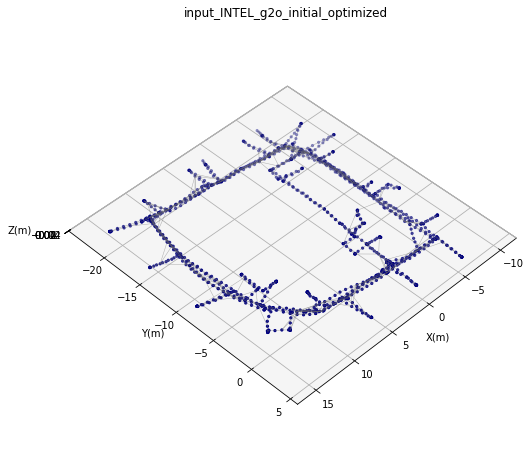

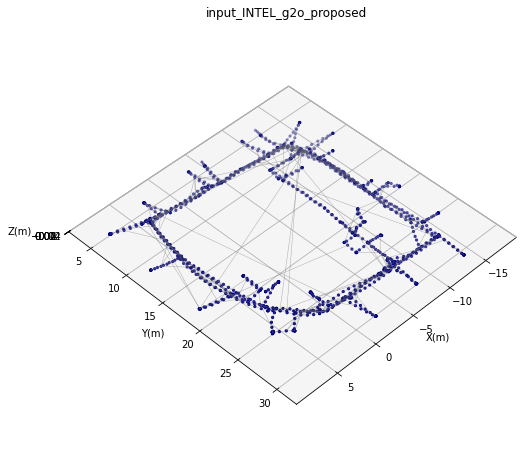

In [8]:
generate_data("/home/xuhao/data/ral2021/raw/input_INTEL_g2o.g2o",  "/home/xuhao/data/ral2021/DGS/input_INTEL_g2o", 10)

Total agents 1 keyframes 3500 edges 5453 inter edge 0 comm_vol 0
Total agents 1 keyframes 3500 edges 5453 inter edge 0 comm_vol 0
Loaded initial optimized
Fix 95 disconnected edges now edges 5548
TSP new path keyframes 12<->1057 cut 1065 comm_vol 1769
Loaded pathes from file.....
Wrote 6613 edges total 5548
mTSP optimizing..... cut 1065 vol 1769  edge_num5548 unb 88.08, kf_num3500
max_time 433.0ms iterations 62, initial 64599.00, final 2.41 totalv 109678

Partition agents 10 .... cut 234 vol 442  edge_num5548  unb 1.12,  kf_num3500
mTSP-NoGreedy optimizing..... cut 234 vol 442  edge_num5548  unb 1.12,  kf_num3500
addition_edges 10 max_time 117.3ms  iterations 39 initial 68480.00 final 2.32 totalv 17238

Partition agents 10 .... cut 257 vol 488  edge_num5548  unb 1.17,  kf_num3500
mTSP-proposed optimizing..... cut 257 vol 488  edge_num5548  unb 1.17,  kf_num3500
addition_edges 3 max_time 223.8ms  iterations 71 initial 64964.30 final 2.86 totalv 34648
Total agents 1 keyframes 3500 edges 

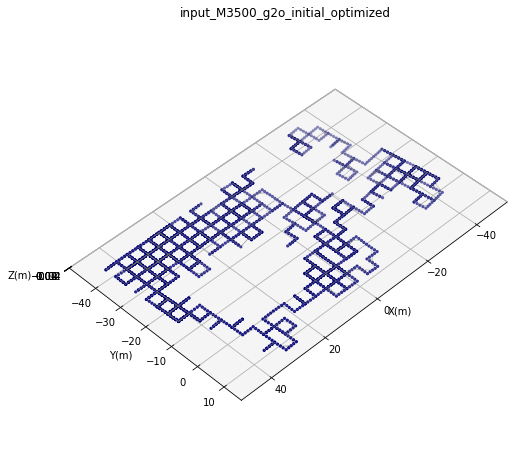

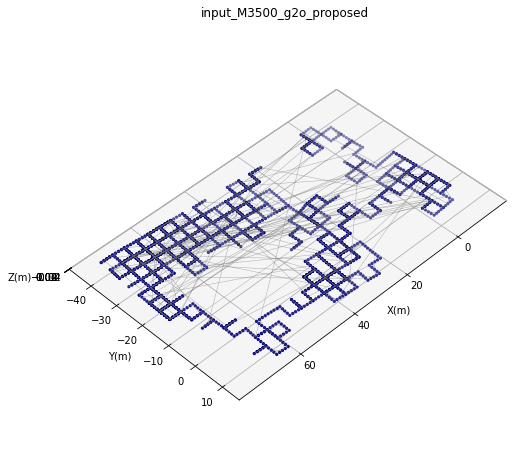

In [9]:
generate_data("/home/xuhao/data/ral2021/raw/input_M3500_g2o.g2o",  "/home/xuhao/data/ral2021/DGS/input_M3500_g2o", 10)

Total agents 1 keyframes 808 edges 827 inter edge 0 comm_vol 0
Total agents 1 keyframes 808 edges 827 inter edge 0 comm_vol 0
Loaded initial optimized
Fix 9 disconnected edges now edges 836
TSP new path keyframes 10<->183 cut 35 comm_vol 70
Loaded pathes from file.....
Wrote 871 edges total 836
mTSP optimizing..... cut 35 vol 70  edge_num836 unb 18.30, kf_num808
max_time 164.3ms iterations 143, initial 177173.80, final 288597.17 totalv 10010

Partition agents 10 .... cut 35 vol 67  edge_num836  unb 1.09,  kf_num808
mTSP-NoGreedy optimizing..... cut 35 vol 67  edge_num836  unb 1.09,  kf_num808
addition_edges 9 max_time 84.8ms  iterations 117 initial 419644.50 final 321.32 totalv 7839

Partition agents 10 .... cut 27 vol 54  edge_num836  unb 1.08,  kf_num808
mTSP-proposed optimizing..... cut 27 vol 54  edge_num836  unb 1.08,  kf_num808
addition_edges 3 max_time 76.3ms  iterations 110 initial 223329.10 final 497.03 totalv 5940
Total agents 1 keyframes 808 edges 839 inter edge 0 comm_vol 0

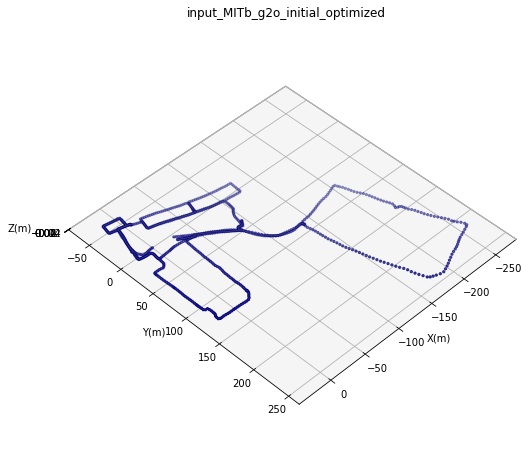

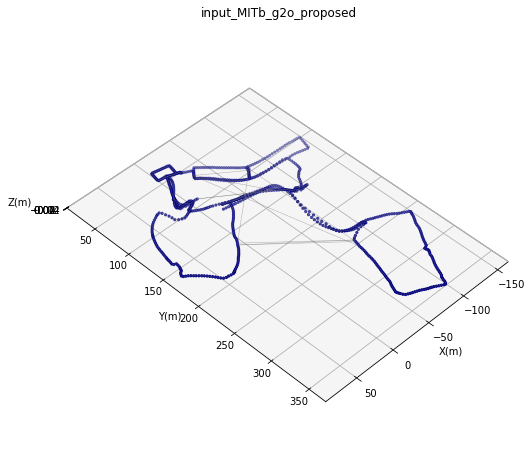

In [10]:
generate_data("/home/xuhao/data/ral2021/raw/input_MITb_g2o.g2o",  "/home/xuhao/data/ral2021/DGS/input_MITb_g2o", 10)

In [ ]:
#Data pre-processing
data_file = "/home/xuhao/data/ral2021/raw/torus3D.g2o"
optimized_file = "/home/xuhao/data/ral2021/torus/parted-initial/fullGraph_optimized.g2o"

pg = PoseGraph()
pg.read_g2o_single(data_file)
pg_optimized = PoseGraph()
pg_optimized.read_g2o_single(optimized_file, cvt_id=True)

new_agent_num = 10
pathes = generate_path_tsp(pg, new_agent_num, random_weight=False, pg_optimized=pg_optimized)

with open('posegraph-torus3D.pickle', 'wb') as handle:
    pickle.dump(pg, handle, protocol=pickle.HIGHEST_PROTOCOL)
np.save("torus3D-pathes.npy",pathes)    

pg.write_to_g2o_folder(f"/home/xuhao/data/pose_graph/posegraph-torus3D", cvt_id=True)